<a href="https://colab.research.google.com/github/adityajhakumar/Earthquake-Detection-System/blob/main/Earthquake%20Detection%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas numpy openpyxl


In [4]:
import pandas as pd
import numpy as np

def generate_realistic_data(num_samples, data_type, start_time=0):
    # Generate time series data in seconds
    time = np.arange(start_time, start_time + num_samples)

    # Simulate accelerometer readings (e.g., in g's)
    if data_type == 'earthquake':
        # Earthquake conditions
        accel_x = np.random.normal(loc=0, scale=1.0, size=num_samples)  # Higher variance
        accel_y = np.random.normal(loc=0, scale=1.0, size=num_samples)
        accel_z = np.random.normal(loc=1, scale=0.2, size=num_samples)  # Gravity pull with some noise
        seismo_readings = np.random.normal(loc=5, scale=3, size=num_samples)  # Stronger signal
    else:
        # Normal conditions
        accel_x = np.random.normal(loc=0, scale=0.1, size=num_samples)  # Low variance
        accel_y = np.random.normal(loc=0, scale=0.1, size=num_samples)
        accel_z = np.random.normal(loc=1, scale=0.05, size=num_samples)  # Gravity pull with very low noise
        seismo_readings = np.random.normal(loc=0, scale=0.5, size=num_samples)  # Background noise

    # Create a DataFrame
    data = {
        'Time': time,
        'Accel_X': accel_x,
        'Accel_Y': accel_y,
        'Accel_Z': accel_z,
        'Seismo_Reading': seismo_readings,
        'Label': data_type
    }
    return pd.DataFrame(data)

# Generate balanced training and testing datasets
num_samples = 1000  # Total samples for each category
train_data_normal = generate_realistic_data(num_samples, 'normal')
train_data_earthquake = generate_realistic_data(num_samples, 'earthquake')

test_data_normal = generate_realistic_data(num_samples // 2, 'normal')
test_data_earthquake = generate_realistic_data(num_samples // 2, 'earthquake')

# Combine normal and earthquake data for train and test sets
train_data = pd.concat([train_data_normal, train_data_earthquake], ignore_index=True)
test_data = pd.concat([test_data_normal, test_data_earthquake], ignore_index=True)

# Shuffle the datasets
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

# Save to Excel
with pd.ExcelWriter('balanced_earthquake_detection_dataset.xlsx', engine='openpyxl') as writer:
    train_data.to_excel(writer, sheet_name='Train', index=False)
    test_data.to_excel(writer, sheet_name='Test', index=False)

print("Balanced dataset created and saved to 'balanced_earthquake_detection_dataset.xlsx'.")


Balanced dataset created and saved to 'balanced_earthquake_detection_dataset.xlsx'.


In [5]:
pip install pandas numpy scikit-learn matplotlib seaborn


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best Cross-Validation Score: 0.9944827481241344
Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       301
           1       0.99      1.00      1.00       299

    accuracy                           0.99       600
   macro avg       1.00      1.00      0.99       600
weighted avg       1.00      0.99      0.99       600



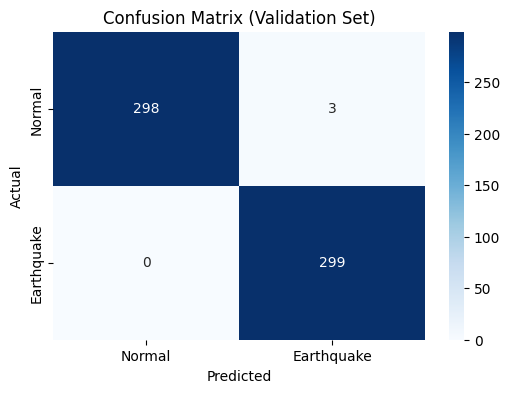

Test Accuracy: 0.99
Synthetic Data Predictions:
         Time   Accel_X   Accel_Y   Accel_Z  Seismo_Reading  Predicted_Label
0  706.248215 -1.575041 -1.688511 -1.100096        5.777394                1
1  193.515300 -0.334322 -0.612882  0.014062        8.349924                1
2  554.767176  0.323370 -1.901407  0.997805        4.954590                1
3  526.316440  0.104811  0.528641 -0.554708        6.957624                1
4  495.470138 -0.475379  1.525075  0.400859        4.976456                1
5  368.550589  0.248155  0.981610 -0.443916        9.615674                1
6  582.733564  1.391127  0.255257 -0.967421        8.533101                1
7  894.457204  1.631142 -1.489257 -0.948200        7.243846                1
8  130.632987 -0.317116  0.697190  0.978059        6.575702                1
9  470.833030 -1.335583  1.870381  1.191697        6.153696                1


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib  # Import joblib for saving the model
from imblearn.over_sampling import SMOTE

# Load the dataset
data = pd.read_excel('balanced_earthquake_detection_dataset.xlsx', sheet_name=None)
train_data = data['Train']
test_data = data['Test']

# Combine train and test data for preprocessing
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Preprocess the data
# Encode the labels
combined_data['Label'] = combined_data['Label'].map({'normal': 0, 'earthquake': 1})

# Split the data into features and target
X = combined_data[['Time', 'Accel_X', 'Accel_Y', 'Accel_Z', 'Seismo_Reading']]
y = combined_data['Label']

# Split into train, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Resample the training data to balance classes using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]  # Adjust class weights
}

# Create a Random Forest model
model = RandomForestClassifier(random_state=42)

# Create a GridSearchCV object for hyperparameter tuning
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2)  # Increased folds for more robust evaluation

# Fit the grid search to the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters and score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Cross-Validation Score: {grid_search.best_score_}')

# Train the final model with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train_resampled, y_train_resampled)

# Validate the model with the validation set
y_val_pred = best_model.predict(X_val_scaled)

# Print evaluation metrics for the validation set
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix for the validation set
confusion_mtx = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Earthquake'],
            yticklabels=['Normal', 'Earthquake'])
plt.title('Confusion Matrix (Validation Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Test the model with the test set
y_test_pred = best_model.predict(X_test_scaled)

# Print test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Save the trained model
joblib.dump(best_model, 'random_forest_model.joblib')

# Save the scaler for later use
joblib.dump(scaler, 'scaler.joblib')

# Function to generate synthetic data for testing the model
def generate_synthetic_data(num_samples=5):
    """ Generate synthetic earthquake data for testing. """
    synthetic_time = np.random.uniform(0, 1000, num_samples)  # Example time values
    synthetic_accel_x = np.random.uniform(-2, 2, num_samples)
    synthetic_accel_y = np.random.uniform(-2, 2, num_samples)
    synthetic_accel_z = np.random.uniform(-2, 2, num_samples)
    synthetic_seismo_reading = np.random.uniform(0, 10, num_samples)  # Example seismic readings

    synthetic_data = pd.DataFrame({
        'Time': synthetic_time,
        'Accel_X': synthetic_accel_x,
        'Accel_Y': synthetic_accel_y,
        'Accel_Z': synthetic_accel_z,
        'Seismo_Reading': synthetic_seismo_reading
    })

    # Scale the synthetic data using the saved scaler
    synthetic_data_scaled = scaler.transform(synthetic_data)

    # Make predictions on synthetic data
    synthetic_predictions = best_model.predict(synthetic_data_scaled)

    return synthetic_data, synthetic_predictions

# Generate and test synthetic data
synthetic_data, synthetic_predictions = generate_synthetic_data(num_samples=10)
synthetic_data['Predicted_Label'] = synthetic_predictions

print("Synthetic Data Predictions:")
print(synthetic_data)


In [31]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Function to generate random synthetic data
def generate_synthetic_data(num_samples):
    # Generate random Time (0 to 1000 seconds)
    time = np.random.uniform(0, 1000, num_samples)

    # Generate random accelerometer readings (X, Y, Z)
    accel_x = np.random.uniform(-2, 2, num_samples)  # Assuming readings can range from -2g to +2g
    accel_y = np.random.uniform(-2, 2, num_samples)
    accel_z = np.random.uniform(-2, 2, num_samples)

    # Generate random Seismo readings (0 to 10)
    seismo_reading = np.random.uniform(0, 10, num_samples)

    # Create a DataFrame
    synthetic_data = pd.DataFrame({
        'Time': time,
        'Accel_X': accel_x,
        'Accel_Y': accel_y,
        'Accel_Z': accel_z,
        'Seismo_Reading': seismo_reading
    })

    return synthetic_data

# Load the pre-trained model and scaler
model = joblib.load('random_forest_model.joblib')
scaler = joblib.load('scaler.joblib')

# Generate synthetic unseen data
num_samples = 1000
synthetic_data = generate_synthetic_data(num_samples)

# Scale the features using the same scaler used during training
# Include 'Time' during transformation
synthetic_data_scaled = scaler.transform(synthetic_data[['Time', 'Accel_X', 'Accel_Y', 'Accel_Z', 'Seismo_Reading']])

# Make predictions on synthetic data
predictions = model.predict(synthetic_data_scaled)

# Create labels for synthetic data using a threshold of 5 for Seismo_Reading
labels = (synthetic_data['Seismo_Reading'] > 5).astype(int)  # Label as earthquake if reading > 5

# Calculate accuracy
accuracy = accuracy_score(labels, predictions)
print(f'Accuracy on Unseen Synthetic Data: {accuracy:.2f}')

# Display some predictions alongside actual labels
result_df = synthetic_data.copy()
result_df['Predicted_Label'] = predictions
result_df['Actual_Label'] = labels
print(result_df.head())  # Show first few rows of the results


Accuracy on Unseen Synthetic Data: 0.53
         Time   Accel_X   Accel_Y   Accel_Z  Seismo_Reading  Predicted_Label  \
0  621.450392  1.038802  1.295220 -1.664139        0.490148                1   
1  995.270397  0.574505  0.709816  1.211396        4.706839                1   
2  148.938584  1.508633  0.040614 -1.628106        9.280521                1   
3  943.848694 -0.866037  1.764666 -0.911131        6.034416                1   
4    0.803181 -0.647824 -1.641081 -1.511845        4.716019                1   

   Actual_Label  
0             0  
1             0  
2             1  
3             1  
4             0  
